In [ ]:
import os, sys
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import Parameter
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import pandas as pd

dataset = 'MNIST'

trans = transforms.Compose([transforms.ToTensor()])

if dataset == 'FashionMNIST':
    train_set = datasets.FashionMNIST('../datasets/fashion_mnist', train=True, download=True, transform=trans)
elif dataset == 'MNIST':
    train_set = datasets.MNIST('../datasets/mnist', train=True, download=True, transform=trans)
    

mnist_data = []
for idx in range(len(train_set)):
    data = {'idx': idx, 'img': train_set[idx][0], 'label': train_set[idx][1].item()}
    mnist_data.append(data)
mnist_df = pd.DataFrame.from_dict(mnist_data)

label_percent = 0.01

frames = []
for digit in range(10):
    frames.append(mnist_df[mnist_df.label == digit].sample(frac=label_percent))
train_labeled_df = pd.concat(frames)
mnist_df = mnist_df.drop(list(train_labeled_df.idx))

train_labeled_df.to_pickle('{}.train_labeled_df.pkl'.format(dataset))
mnist_df.to_pickle('{}.train_unlabeled_df.pkl'.format(dataset))

In [1]:
import torch
from torch.utils.data import Dataset
import pandas as pd

######################################################################################################################
class SemiSupervisedDataset(Dataset):
    def __init__(self, dataset, label=True):
        self.label = label
        if label:
            self.df = pd.read_pickle('{}.train_labeled_df.pkl'.format(dataset))
        else:
            self.df = pd.read_pickle('{}.train_unlabeled_df.pkl'.format(dataset))
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img = self.df.iloc[idx].img
        label = int(self.df.iloc[idx].label)
        return (img, label)
    
######################################################################################################################
batch_size = 64
z_dim = 62
y_dim = 10

dataset = 'MNIST'

labeled_train_set = SemiSupervisedDataset(dataset, label=True)
unlabeled_train_set = SemiSupervisedDataset(dataset, label=False)

labeled_train_loader = torch.utils.data.DataLoader(dataset=labeled_train_set, batch_size=batch_size, shuffle=True)
unlabeled_train_loader = torch.utils.data.DataLoader(dataset=unlabeled_train_set, batch_size=batch_size, shuffle=True)

In [2]:
import os, sys
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class CVAE_Gumbel(nn.Module):
    def __init__(self, dataset, latent_dim, num_classes, device):
        super(CVAE_Gumbel, self).__init__()
        
        self.dataset = dataset
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.device = device
        
        if dataset == 'MNIST':
            self.input_dim = 1 # the number of input channel 
            self.input_height = 28
            self.input_width = 28
        else:
            assert(False)
            
        # encoder
        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )
        self.fc1 = nn.Sequential(
            nn.Linear(128 * (self.input_height // 4) * (self.input_width // 4), 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2)
        )
        self.h_to_mu = nn.Sequential(nn.Linear(1024, self.latent_dim))
        self.h_to_logvar = nn.Sequential(nn.Linear(1024, self.latent_dim),
                                         nn.Sigmoid())
        
        if dataset == 'MNIST':
            self.generator_input_dim = latent_dim + num_classes
            self.output_dim = 1
        else:
            assert(False)
            
        # decoder
        self.fc2 = nn.Sequential(
            nn.Linear(self.generator_input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 128 * (self.input_height // 4) * (self.input_width // 4)),
            nn.BatchNorm1d(128 * (self.input_height // 4) * (self.input_width // 4)),
            nn.ReLU(),
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, self.output_dim, 4, 2, 1),
            nn.Sigmoid(),
        )
        
        # discriminator
        self.discrim_conv = nn.Sequential(
            nn.Conv2d(self.input_dim, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )
        self.fc3 = nn.Sequential(
            nn.Linear(128 * (self.input_height // 4) * (self.input_width // 4), 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.num_classes)
        )
        
        
    def reparametrize(self, mu, logvar):
        std = torch.sqrt(torch.exp(logvar))
        eps = torch.randn_like(logvar)
        return eps.mul(std).add_(mu)
    
    def encode(self, input):
        x = self.conv(input)
        x = x.view(-1, 128 * (self.input_height // 4) * (self.input_width // 4))
        h = self.fc1(x)
        
        z_mu = self.h_to_mu(h)
        z_logvar = self.h_to_logvar(h)
        return z_mu, z_logvar
    
    def decode(self, input, label):
        zy = torch.cat([input, label], 1)
        h = self.fc2(zy)
        h = h.view(-1, 128, (self.input_height // 4), (self.input_width // 4))
        x_hat = self.deconv(h)
        return x_hat
    
    def predict(self, input, opt=None):
        '''
            opt : specify the post-processing of the unnormalized scores
                Three options are: None, softmax, log_softmax
                None: no further post-processing
                softmax: apply softmax
                log_softmax: apply log_softmax
            Return the prediction scores for each class
        '''
        x = self.discrim_conv(input)
        x = x.view(-1, 128 * (self.input_height // 4) * (self.input_width // 4))
        h = self.fc3(x)
        
        if opt is None:
            return h
        elif opt == 'softmax':
            return F.softmax(h, dim=1)
        elif opt == 'log_softmax':
            return F.log_softmax(h, dim=1)
        else:
            assert(False) # unknown options
        return None
    
    def forward(self, input, label=None):
        z_mu, z_logvar = self.encode(input)
        z = self.reparametrize(z_mu, z_logvar)
        
        if label is None:
            label = self.predict(input)
        x_hat = self.decode(z, label)
        return x_hat, z_mu, z_logvar

In [3]:
mse_loss = nn.MSELoss(size_average=False, reduce=True)
unlabeled_mse_loss = nn.MSELoss(reduce=False)
CE_loss = torch.nn.CrossEntropyLoss(reduce=False)

def compute_kl_loss(mu, logvar):
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element, dim=1)
    KLD = KLD.mul(-0.5)
    return KLD

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"]="3"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = CVAE_Gumbel(dataset, z_dim, y_dim, device).to(device)

In [5]:
num_epochs = 20
optimizer = optim.Adam(model.parameters(), lr=0.001)

kl_weight = 0.
kl_step = 1 / 15000.

alpha = 0.001

for epoch in range(num_epochs):
    avg_loss = []
    
    # train the supervised learning model
    for xb, yb in labeled_train_loader:
        y_onehot = torch.zeros((xb.size(0), y_dim))
        y_onehot = y_onehot.scatter_(1, yb.unsqueeze(1), 1)

        xb = xb.to(device)
        y_onehot = y_onehot.to(device)
        
        xb_hat, z_mu, z_logvar = model(xb, y_onehot)
        kl_loss = compute_kl_loss(z_mu, z_logvar)
        kl_loss = kl_loss.mean()
        reconstr_loss = mse_loss(xb_hat, xb)
       
        # train the discriminator
        scores = model.predict(xb)
        pred_loss = CE_loss(scores, yb.to(device))
        pred_loss = pred_loss.mean()
        
        loss = reconstr_loss + kl_weight * kl_loss + alpha * pred_loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        kl_weight = min(kl_weight + kl_step, 1.0)
        avg_loss.append(loss.item())
    
    print('epoch:{} supervised loss:{:.4f}'.format(epoch, np.mean(avg_loss)))
    
    avg_loss = []
    # train the unsupervised learning model
    for xb, _ in unlabeled_train_loader:
        xb = xb.to(device)

        avg_vae_loss = []
        
        logits = model.predict(xb)
        q_y_given_x = model.predict(xb, opt='softmax')

        for j in range(1):
            # sample a category from the logits using gumbel_softmax 
            y_onehot = F.gumbel_softmax(logits, tau=1.0, hard=False, eps=1e-10)

            # compute weight for the current batch
            weights = 1.0 #torch.log((q_y_given_x * y_onehot).sum(dim=1))

            xb_hat, z_mu, z_logvar = model(xb, y_onehot)
            kl_loss = compute_kl_loss(z_mu, z_logvar)
            reconstr_loss = unlabeled_mse_loss(xb_hat, xb)
            reconstr_loss = reconstr_loss.sum(dim=3).sum(dim=2).sum(dim=1)

            vae_loss = weights * (reconstr_loss + (kl_weight * kl_loss))
            avg_vae_loss.append(vae_loss)
        
        avg_vae_loss = torch.stack(avg_vae_loss, dim=1).mean(dim=1)
        
        # compute entropy
        log_q_y_given_x = model.predict(xb, opt='log_softmax')
        entropy_q_y_given_x = -1.0 * (q_y_given_x * log_q_y_given_x).sum(dim=1)

        loss = (avg_vae_loss + entropy_q_y_given_x).mean()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        kl_weight = min(kl_weight + kl_step, 1.0)
        avg_loss.append(loss.item())

    print('epoch:{} unsupervised loss:{:.4f}'.format(epoch, np.mean(avg_loss)))

epoch:0 supervised loss:8588.5028
epoch:0 unsupervised loss:44.2963
epoch:1 supervised loss:2025.0105
epoch:1 unsupervised loss:29.1358
epoch:2 supervised loss:1067.8837
epoch:2 unsupervised loss:25.1460
epoch:3 supervised loss:897.8239
epoch:3 unsupervised loss:26.8162
epoch:4 supervised loss:869.8567
epoch:4 unsupervised loss:28.3559
epoch:5 supervised loss:886.1428
epoch:5 unsupervised loss:29.5888
epoch:6 supervised loss:874.6824
epoch:6 unsupervised loss:30.6722
epoch:7 supervised loss:876.6393
epoch:7 unsupervised loss:31.8971
epoch:8 supervised loss:888.3998
epoch:8 unsupervised loss:32.6391
epoch:9 supervised loss:901.7700
epoch:9 unsupervised loss:33.3183
epoch:10 supervised loss:904.8068
epoch:10 unsupervised loss:34.1813
epoch:11 supervised loss:934.9561
epoch:11 unsupervised loss:34.4896
epoch:12 supervised loss:950.7444
epoch:12 unsupervised loss:35.3406
epoch:13 supervised loss:952.5809
epoch:13 unsupervised loss:35.6817
epoch:14 supervised loss:933.3425
epoch:14 unsuperv

In [6]:
# fixed noise & condition
sample_num = 100
sample_z_ = torch.zeros((sample_num, z_dim))
for i in range(10):
    sample_z_[i*y_dim] = torch.randn(1, z_dim)
    for j in range(1, y_dim):
        sample_z_[i*y_dim + j] = sample_z_[i*y_dim]
        
temp = torch.zeros((10, 1))
for i in range(y_dim):
    temp[i, 0] = i
    
temp_y = torch.zeros((sample_num, 1))
for i in range(10):
    temp_y[i*y_dim: (i+1)*y_dim] = temp
    
sample_y_ = torch.zeros((sample_num, y_dim))
sample_y_.scatter_(1, temp_y.type(torch.LongTensor), 1); # convert to one-hot

with torch.no_grad():
    sample_z_ = sample_z_.to(device)
    sample_y_ = sample_y_.to(device)
    samples = model.decode(sample_z_, sample_y_)
    samples = samples.permute(0, 2, 3, 1).data.cpu().numpy()
    np.save('samples.cvae', samples)

([], <a list of 0 Text yticklabel objects>)

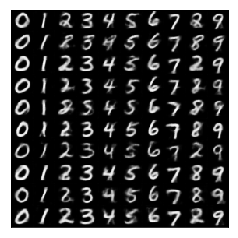

In [7]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.utils as vutils

sample_images = np.load('samples.cvae.npy')
sample_images = sample_images.reshape(10, 10, 28, 28, 1).squeeze()

full_images = []
for i in range(10):
    tmp = [sample_images[i, j, :, :] for j in range(10)]
    full_images.append(np.hstack(tmp))
full_images = np.vstack(full_images)   

plt.imshow(full_images, cmap='gray')
plt.xticks([])
plt.yticks([])